# 데이터 준비와 확인
---

In [70]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# read data
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

display(train_data.head())
display(test_data.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 데이터로더 구성
---
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.           
그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다.        
이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [71]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
display(word_to_index)

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [72]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [73]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공 
---
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [74]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리시트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준 편차 : ', np.std(num_tokens))

# 예를 들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences max len : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준 편차 :  12.843571191092
pad_sequences max len :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [75]:
# 처음 몇 개 인덱스는 사전에 정의 되어 있다.
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"],
                                                    padding='pre', # 혹은 'pre'
                                                    maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                   value=word_to_index['<PAD>'],
                                                   padding='pre',  # 혹은 'pre'
                                                   maxlen=maxlen)
display(index_to_word)

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

# 모델구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해보자

## RNN Model

In [86]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM레이어를 사용. 이 때 LSTM state 벡터의 차원수는 8(변경 가능)
rnn_model.add(keras.layers.Dense(8, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim이다.

rnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


## CNN Model

In [87]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(8, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 16)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_41 (Dense)             (None, 1)               

## GlobalMaxPooling 하나만 사용
전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

In [88]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

gmp_model = keras.Sequential()
gmp_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(keras.layers.GlobalMaxPooling1D())
gmp_model.add(keras.layers.Dense(8, activation='relu'))
gmp_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 16)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### Validation Set 구성

In [89]:
# validation set 80000건 분리
x_val = X_train[:80000]
y_val = y_train[:80000]

# validation set을 제외한 나머지
partial_X_train = X_train[80000:]
partial_y_train = y_train[80000:]

print(partial_X_train.shape)
print(x_val.shape)

(66182, 41)
(80000, 41)


# 모델 훈련 개시
---

### RNN 모델 학습 및 평가

In [90]:
rnn_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보자

rnn_history = rnn_model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

rnn_results = rnn_model.evaluate(X_test, y_test, verbose=2)

print(rnn_results)

Epoch 1/10
130/130 [==============================] - 4s 17ms/step - loss: 0.6549 - accuracy: 0.6304 - val_loss: 0.4558 - val_accuracy: 0.8242
Epoch 2/10
130/130 [==============================] - 2s 14ms/step - loss: 0.4089 - accuracy: 0.8394 - val_loss: 0.3710 - val_accuracy: 0.8415
Epoch 3/10
130/130 [==============================] - 2s 14ms/step - loss: 0.3318 - accuracy: 0.8663 - val_loss: 0.3667 - val_accuracy: 0.8425
Epoch 4/10
130/130 [==============================] - 2s 14ms/step - loss: 0.3009 - accuracy: 0.8813 - val_loss: 0.3642 - val_accuracy: 0.8430
Epoch 5/10
130/130 [==============================] - 2s 14ms/step - loss: 0.2809 - accuracy: 0.8910 - val_loss: 0.3788 - val_accuracy: 0.8354
Epoch 6/10
130/130 [==============================] - 2s 14ms/step - loss: 0.2698 - accuracy: 0.8952 - val_loss: 0.3786 - val_accuracy: 0.8398
Epoch 7/10
130/130 [==============================] - 2s 14ms/step - loss: 0.2586 - accuracy: 0.9013 - val_loss: 0.3859 - val_accuracy: 0.8393

### CNN 모델 학습 및 평가

In [91]:
cnn_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보자

cnn_history = cnn_model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

cnn_results = cnn_model.evaluate(X_test, y_test, verbose=2)

print(cnn_results)

Epoch 1/10
130/130 [==============================] - 6s 30ms/step - loss: 0.6601 - accuracy: 0.6128 - val_loss: 0.3971 - val_accuracy: 0.8234
Epoch 2/10
130/130 [==============================] - 1s 10ms/step - loss: 0.3597 - accuracy: 0.8440 - val_loss: 0.3602 - val_accuracy: 0.8428
Epoch 3/10
130/130 [==============================] - 1s 10ms/step - loss: 0.3038 - accuracy: 0.8725 - val_loss: 0.3585 - val_accuracy: 0.8437
Epoch 4/10
130/130 [==============================] - 1s 10ms/step - loss: 0.2769 - accuracy: 0.8900 - val_loss: 0.3656 - val_accuracy: 0.8441
Epoch 5/10
130/130 [==============================] - 1s 10ms/step - loss: 0.2416 - accuracy: 0.9053 - val_loss: 0.3754 - val_accuracy: 0.8431
Epoch 6/10
130/130 [==============================] - 1s 10ms/step - loss: 0.2174 - accuracy: 0.9188 - val_loss: 0.3922 - val_accuracy: 0.8408
Epoch 7/10
130/130 [==============================] - 1s 10ms/step - loss: 0.1893 - accuracy: 0.9318 - val_loss: 0.4136 - val_accuracy: 0.8382

### GlobalMaxPooling 하나만 사용

In [92]:
gmp_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보자

gmp_history = gmp_model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

gmp_results = gmp_model.evaluate(X_test, y_test, verbose=2)

print(gmp_results)

Epoch 1/10
130/130 [==============================] - 2s 8ms/step - loss: 0.6776 - accuracy: 0.6242 - val_loss: 0.5765 - val_accuracy: 0.7926
Epoch 2/10
130/130 [==============================] - 1s 6ms/step - loss: 0.5263 - accuracy: 0.8153 - val_loss: 0.4245 - val_accuracy: 0.8226
Epoch 3/10
130/130 [==============================] - 1s 7ms/step - loss: 0.3861 - accuracy: 0.8481 - val_loss: 0.3788 - val_accuracy: 0.8340
Epoch 4/10
130/130 [==============================] - 1s 6ms/step - loss: 0.3286 - accuracy: 0.8655 - val_loss: 0.3668 - val_accuracy: 0.8381
Epoch 5/10
130/130 [==============================] - 1s 6ms/step - loss: 0.2937 - accuracy: 0.8807 - val_loss: 0.3653 - val_accuracy: 0.8403
Epoch 6/10
130/130 [==============================] - 1s 7ms/step - loss: 0.2707 - accuracy: 0.8931 - val_loss: 0.3696 - val_accuracy: 0.8404
Epoch 7/10
130/130 [==============================] - 1s 7ms/step - loss: 0.2466 - accuracy: 0.9049 - val_loss: 0.3770 - val_accuracy: 0.8398
Epoch 

# Loss, Accuracy 그래프 시각화
---

### RNN Loss, Accuracy 그래프

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


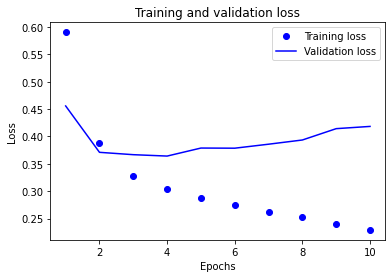

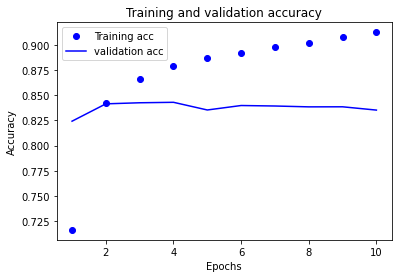

In [93]:
import matplotlib.pyplot as plt


history_dict = rnn_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"이다.
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b"는 "파란 실선"이다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN Loss, Accuracy 그래프

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


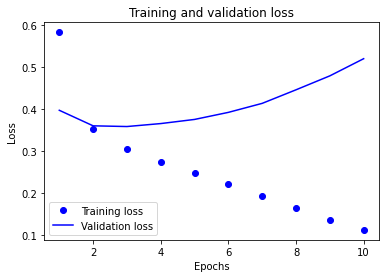

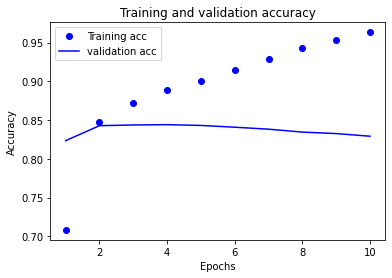

In [94]:
history_dict = cnn_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"이다.
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b"는 "파란 실선"이다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling Loss, Accuracy 그래프

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


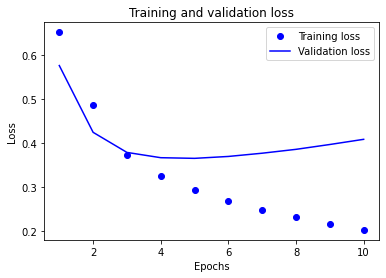

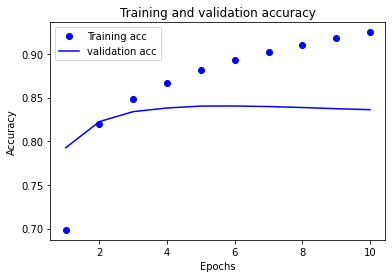

In [95]:
history_dict = gmp_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"이다.
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b"는 "파란 실선"이다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석
---

In [114]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [115]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장한다.
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록한다.
vectors = model.get_weights()[0]
display(index_to_word)
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()



{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

In [116]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.08196547,  0.13693866,  0.15983677, -0.00418616,  0.03967798,
        0.02169253,  0.08657318, -0.05651317,  0.00740912, -0.13397603,
       -0.04285666,  0.00861263,  0.1917205 , -0.11368261, -0.28034413,
        0.03558016], dtype=float32)

In [117]:
#워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다.
word_vectors.similar_by_word("영화")

[('점', 0.9279258251190186),
 ('네요', 0.9136362671852112),
 ('음', 0.9057154655456543),
 ('어요', 0.8941637277603149),
 ('만행', 0.8917593955993652),
 ('다', 0.8912827968597412),
 ('든다', 0.8820219039916992),
 ('맥스', 0.879548192024231),
 ('드라마', 0.8741573095321655),
 ('.', 0.864897608757019)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [118]:
#! pip install --upgrade gensim==3.8.3

In [119]:
from gensim.models import KeyedVectors
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False, limit=1000000, unicode_errors='ignore', encoding='utf-8')
#word2vec = gensim.models.Word2Vec.load(os.path.join(word2vec_path, 'ko.bin')) 
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [120]:
word2vec.similar_by_word('영화')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

In [121]:
vocab_size = 10000 # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200 # 워드 벡터의 차원 수(변경 가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [122]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000 # 어휘 사전의 크기 입니다.(10,000 개의 단어)
word_vector_dim = 200 # 워드 벡터의 차원 수(변경 가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                word_vector_dim,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=maxlen,
                                trainable=True)) # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [123]:
# 학습의 진행
model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

epochs = 10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보자.

hisotry = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
266/266 [==============================] - 8s 27ms/step - loss: 0.6099 - accuracy: 0.6429 - val_loss: 0.4428 - val_accuracy: 0.7961
Epoch 2/10
266/266 [==============================] - 7s 25ms/step - loss: 0.4262 - accuracy: 0.8058 - val_loss: 0.3888 - val_accuracy: 0.8238
Epoch 3/10
266/266 [==============================] - 7s 25ms/step - loss: 0.3613 - accuracy: 0.8401 - val_loss: 0.3887 - val_accuracy: 0.8212
Epoch 4/10
266/266 [==============================] - 6s 24ms/step - loss: 0.3249 - accuracy: 0.8593 - val_loss: 0.3471 - val_accuracy: 0.8462
Epoch 5/10
266/266 [==============================] - 6s 24ms/step - loss: 0.2998 - accuracy: 0.8747 - val_loss: 0.3471 - val_accuracy: 0.8474
Epoch 6/10
266/266 [==============================] - 6s 24ms/step - loss: 0.2837 - accuracy: 0.8812 - val_loss: 0.3441 - val_accuracy: 0.8528
Epoch 7/10
266/266 [==============================] - 6s 24ms/step - loss: 0.2674 - accuracy: 0.8905 - val_loss: 0.3383 - val_accuracy: 0.8552

In [124]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3658 - accuracy: 0.8510
[0.3658158481121063, 0.851028323173523]


# 회고
---

- 이번 프로젝트에서 **어려웠던 점,**                                
: KeyedVectors.load_word2vec_format() 함수 사용 시, 버전상 문제로 인하여 지속적으로 에러가 발생하였는데, Agit에서 팁을 얻어 해결할 수 있었다.
    
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
    1. Optimizer 기법의 종류와 특성을 알 수 있었다.(구체적인 동작 방식은 이해가 되지 않았다)
    (https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam)
    2. epochs 를 무조건 늘린다고 좋은게 아니다.      
    3. Embedding 기법에 대한 이해
학습 중 Accuracy는 오를 수 있다고 해도 Overfitting 되어 test 시 accuracy 가 떨어질 수 있다.

- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**         
내가 만든 워드벡터사전으로는 3가지 모델의 accuracy가         
RNN : 0.833024799823761        
CNN : 0.8247858881950378           
GlobalMaxPooling : 0.832129716873169 가 나왔다.        
처음 한국어 Word2Vec 임베딩 활용을 하여도 83퍼센트 정도가 나왔다.
그래서 Optimizer 변경을 하였고, epoch를 변경해가며 시도해 보았다.
변경 시에도, Accuracy가 루브릭 이상이 안나온다면 워드벡터에 들어가는 'ㅋㅋㅋ', '!!', '.', '..', ',' 등을 삭제하고 시도해보려고 했으나 위에 두 변경점으로 Accuracy가 루브릭 이상이 나와 따로 시도하지 않았다.

- **자기 다짐**        
: 시간적 여유를 두고 루브릭에만 만족하지말고 추가 실험을 해보자....